Imports

In [124]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import pandas as pd
import tensorflow as tf
import cv2
import gc
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import datasets, layers, models
from keras.utils import to_categorical

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# 0. How this notebook is structured

- In section 1 we read the data, shuffle it, standardize it, and expand the validation set. You must run this in its entirety
- In section 2 we train the model - Just skip this and go to section 3 and load the model if you don't want to train something ne
- In section 4 we test the model and output some performance indicators

Each section has additional info

## 1. Read Data and Format

You must Specify the datatype that you will use
- comressed is processed + autoencoded
- processed data is much slower than compressed
- you should have these data at hand in the relevant folder , use the autoencoder.ipynb if you dont have them

In [125]:
# data_type = "processed" 
data_type = "compressed"

In [126]:

# Uncomment to pick the processed or compressed data


# For some reason realtive path does not work so paste in your absolute path
folder = f"../../Data_{data_type}"
# folder = f"/Users/feyzjan/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/Programming/GithubRepos/Project-CS7641/Data_{data_type}"

labels = {'NORMAL':0, 'COVID19':1, 'PNEUMONIA':2, 'TURBERCULOSIS':3}


# change this to match your imagedimension
X_train = np.empty((0,128,256))
X_val = np.empty((0,128,256))
X_test = np.empty((0,128,256))
y_train = np.empty((0,))
y_val = np.empty((0,))
y_test = np.empty((0,))



# Loop through each dataset and store in the appropriate list
for dataset in ['train', 'test', 'val']:
    for disease in ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']:
        
        path = os.path.join(folder, dataset, disease)
        # print(path)
        # Read all jpeg files in that folder
        all_files = [f for f in os.listdir(path) if f.endswith('.jpeg') or f.endswith('.jpg') or f.endswith('.png')]
        all_files.sort()

        # read images
        images = [cv2.imread(os.path.join(path, file)) for file in all_files]
        
        # Store in the appropriate list :  variable file naming
        var_name = f"X_{dataset.lower()}_{disease.lower()}"
        exec(f"{var_name} = np.array(images)")
        print(var_name)

        # Remove the three color values and keep grayscale
        exec(f"{var_name} = np.array([cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) for image in {var_name}])")

        # Create label
        y_var_name = f"y_{dataset.lower()}_{disease.lower()}"
        exec(f"{y_var_name} = np.full(len(images), labels[disease])")
        print(y_var_name)

        # Append to the main list
        # exec(f"X_{dataset.lower()} = np.append(X_{dataset.lower()}, {var_name}, axis=0)")
        try:
            exec(f"X_{dataset.lower()} = np.vstack((X_{dataset.lower()}, {var_name}))")
            exec(f"y_{dataset.lower()} = np.append(y_{dataset.lower()}, {y_var_name})")
        except ValueError:
            print(f" error in {var_name}")
# Now you got separate lists like train_covid, test_normal, etc. filled with images


X_train_covid19
y_train_covid19
X_train_normal
y_train_normal
X_train_pneumonia
y_train_pneumonia
X_train_turberculosis
y_train_turberculosis
X_test_covid19
y_test_covid19
X_test_normal
y_test_normal
X_test_pneumonia
y_test_pneumonia
X_test_turberculosis
y_test_turberculosis
X_val_covid19
y_val_covid19
X_val_normal
y_val_normal
X_val_pneumonia
y_val_pneumonia
X_val_turberculosis
y_val_turberculosis


First lets combine train and val

In [127]:
X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape

((6326, 128, 256), (771, 128, 256), (38, 128, 256), (6326,), (771,), (38,))

In [128]:
X_train = np.concatenate([X_train, X_val], axis = 0)
y_train = np.concatenate([y_train, y_val], axis = 0)

Shuffle values

In [129]:
X_train, y_train = shuffle(X_train, y_train, random_state=42)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

Divide everything by 255 to standardize them

In [130]:
X_train /= 255
X_test /= 255

One Hot Encode output labels

In [131]:
print(y_train.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

(6364,)


### Investigate Class Imbalances - New

In [132]:
y_train_old = np.argmax(y_train, axis=1)
y_test_old = np.argmax(y_test, axis=1)

In [133]:
unique, counts = np.unique(y_train_old, return_counts=True)
counts = np.round(counts/len(y_train_old), 4)
dict(zip(unique, counts))
print("Train class distribution: ", dict(zip(unique, counts)))

unique, counts = np.unique(y_test_old, return_counts=True)
counts = np.round(counts/len(y_test_old), 2)
dict(zip(unique, counts))
print("Test class distribution: ", dict(zip(unique, counts)))

Train class distribution:  {0: 0.212, 1: 0.0739, 2: 0.6102, 3: 0.104}
Test class distribution:  {0: 0.3, 1: 0.14, 2: 0.51, 3: 0.05}


Do the upsampling

In [134]:
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split

In [135]:
# y_train = y_train_old.copy()

In [136]:
# print("Class distribution in y_train before SMOTE:\n", np.bincount(y_train))

In [137]:
# # Flattening the image data
# num_images, img_height, img_width = X_train.shape
# X_train_flattened = X_train.reshape(num_images, img_height * img_width)

# # Applying SMOTE
# smote = SMOTE()
# X_train_upsampled, y_train_upsampled = smote.fit_resample(X_train_flattened, y_train)

# # Reshaping the upsampled data back to the original image format (if needed)
# X_train_upsampled = X_train_upsampled.reshape(-1, img_height, img_width)

In [138]:
# print("Class distribution in y_train after SMOTE:\n", np.bincount(y_train_upsampled))

In [139]:
# X_train = X_train_upsampled
# y_train = to_categorical(y_train_upsampled)

### The validation data is very small so I will make it 10% of training data

In [140]:
ten_percent = int(0.1 * len(X_train))
random_indices = np.random.choice(len(X_train), ten_percent, replace=False)

X_val = X_train[random_indices]
y_val = y_train[random_indices]

X_train = np.delete(X_train, random_indices, axis=0)
y_train = np.delete(y_train, random_indices, axis=0)

print(y_train.shape, y_val.shape, y_test.shape)

(5728, 4) (636, 4) (771, 4)


Print input shapes

In [141]:
n1, n2 = X_train[0].shape
print(n1, n2)

128 256


New - assign class weights

In [142]:
class_weights = {
    0: 2.0,  # Increase the weight for class 0
    1: 0.5,  # Normal weight for class 1,2,3
    2: 1.5,  
    3: 0.5   
}

TO DO Attempts for improvements:
- Run current configuration once
- Experiment with class weights
- Use focal loss function
- Simplify model further

## 2. Define Model and Train (Or skip this and go to 3. Load Model) 

In [143]:
from keras import regularizers

New loss function

In [171]:
import tensorflow as tf
from tensorflow.keras import backend as K

def focal_loss(alpha, gamma=2.0):
    """
    Focal loss for multi-class classification.

    Args:
      alpha: List of weights for each class.
      gamma: Focusing parameter.

    Returns:
      A loss function callable.
    """
    alpha = tf.constant(alpha, dtype=tf.float32)

    def focal_loss_fixed(y_true, y_pred):
        """
        Focal loss function for multi-class classification.

        Args:
          y_true: Ground truth labels, shape of [batch_size, num_classes].
          y_pred: Predicted probabilities, shape of [batch_size, num_classes].

        Returns:
          Focal loss value.
        """
        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in batch
        return K.mean(K.sum(loss, axis=-1))

    return focal_loss_fixed


In [172]:
# Assign higher weight to class 0, equal weights for class 1 and 2
class_weights = [4.0, 1.0, 1.0, 1.0]  

loss_function = loss=focal_loss(alpha=class_weights)

In [173]:
model = models.Sequential()

# Conv Layer 1 - Gradually increase convolution sizes
model.add(layers.Conv2D(8, (3, 3), activation='relu', input_shape=(n1, n2, 1)))

# MaxPool 1 - Reduce dimensionality while keeping features.
model.add(layers.MaxPooling2D((2, 2)))

# Conv Layer 3 
model.add(layers.Conv2D(16, (3, 3), activation='relu'))
# Why? Even more filters, even more complex features.

# MaxPool 3 
model.add(layers.MaxPooling2D((2, 2)))

# Conv Layer 4 - Max out the complexity we can model with 512 filters.
model.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Flatten - need to flatten before passing to Dense layers.
model.add(layers.Flatten())

# Dense 1 - High-level feature learning before the final layer.
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))

# Dropout - Regularization
model.add(layers.Dropout(0.5))

# Output
model.add(layers.Dense(4, activation='softmax'))

In [174]:
model.compile(optimizer='adam',
              loss = loss_function,
              metrics=['accuracy'])

In [176]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=6, verbose=1, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, 
                    shuffle=True,
                    batch_size = 1, 
                    validation_data=(X_val, y_val)
                    ,callbacks=[early_stopping]
                    # ,class_weight=class_weights
                    , verbose = 1) 

Epoch 1/20
5728/5728 [==============================] - 57s 10ms/step - loss: 0.3537 - accuracy: 0.7877 - val_loss: 0.2129 - val_accuracy: 0.8475
Epoch 2/20
5728/5728 [==============================] - 39s 7ms/step - loss: 0.2028 - accuracy: 0.8591 - val_loss: 0.1771 - val_accuracy: 0.8836
Epoch 3/20
5728/5728 [==============================] - 40s 7ms/step - loss: 0.1607 - accuracy: 0.8916 - val_loss: 0.1148 - val_accuracy: 0.9450
Epoch 4/20
5728/5728 [==============================] - 39s 7ms/step - loss: 0.1380 - accuracy: 0.9071 - val_loss: 0.1155 - val_accuracy: 0.9167
Epoch 5/20
5728/5728 [==============================] - 39s 7ms/step - loss: 0.1132 - accuracy: 0.9211 - val_loss: 0.1104 - val_accuracy: 0.9450
Epoch 6/20
5728/5728 [==============================] - 41s 7ms/step - loss: 0.1054 - accuracy: 0.9289 - val_loss: 0.1225 - val_accuracy: 0.9308
Epoch 7/20
5728/5728 [==============================] - 42s 7ms/step - loss: 0.0896 - accuracy: 0.9419 - val_loss: 0.1122 - val_a

Plot validation and train data accuracy history

In [177]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


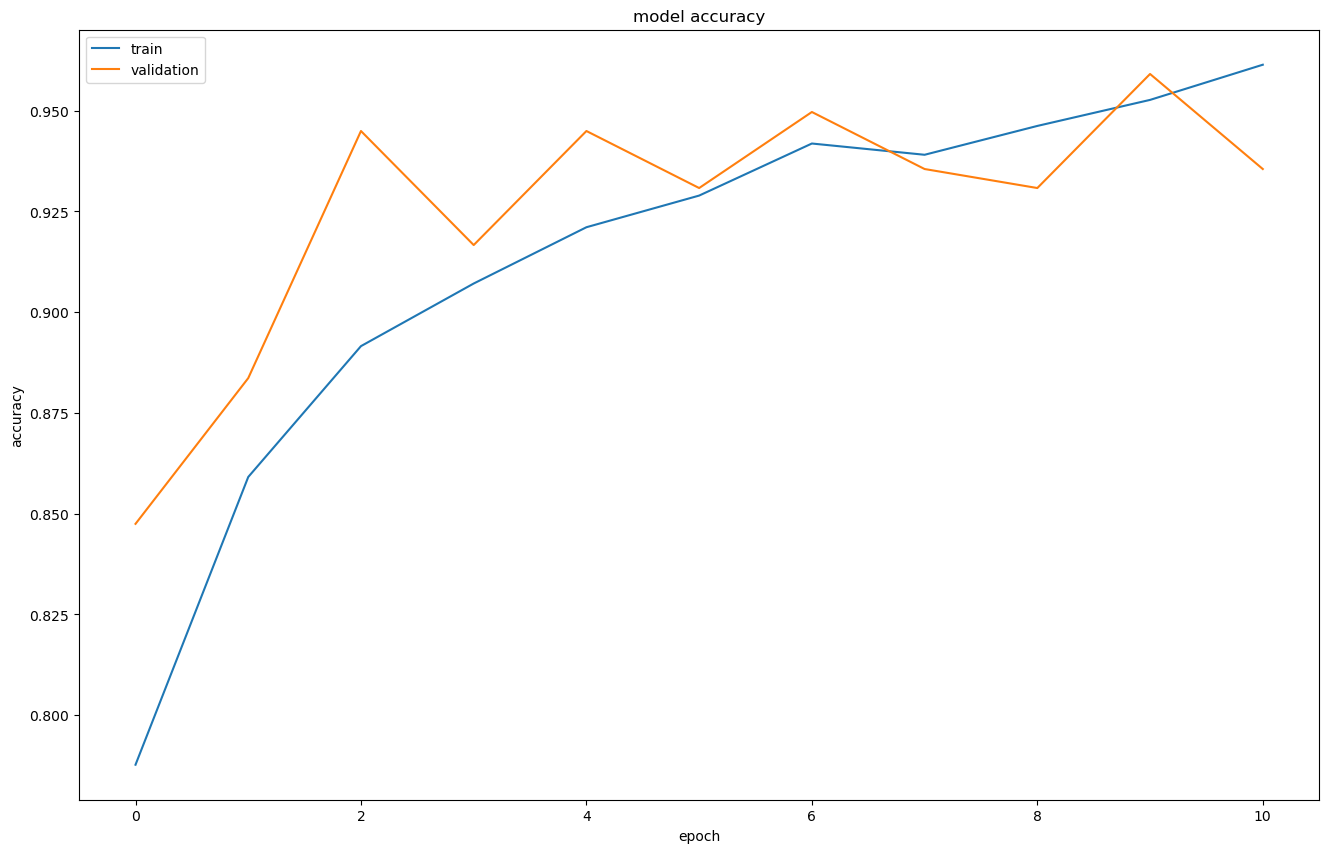

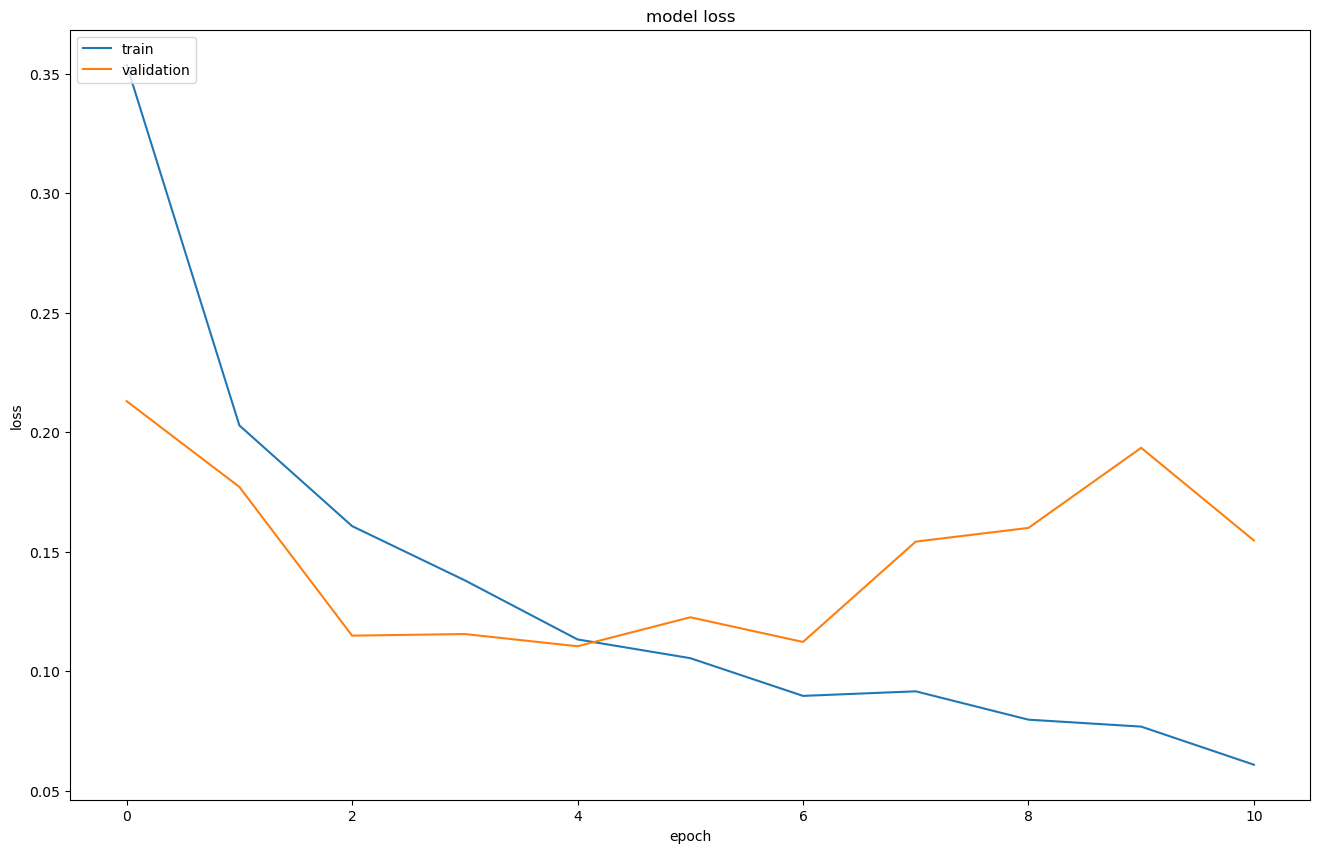

In [178]:
# summarize history for accuracy
plt.figure(figsize=(16,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.figure(figsize=(16,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

### 2.9 Save model

- If you train a new model and save it, name it something else so it doesnt overwrite an existing one

In [187]:
version = 2
model.save(f'trained_models/CNNV{version}_{data_type}images')

INFO:tensorflow:Assets written to: trained_models/CNNV2_compressedimages\assets


INFO:tensorflow:Assets written to: trained_models/CNNV2_compressedimages\assets


## 3. Load model

Pick version to use, there should be two models for each version, one for compressed and one for processed images

In [193]:
model = 0

In [197]:
# # Specify the version you want to load
data_type = "processed"
version = 2
model_to_load =  f"trained_models/CNNV{version}_{data_type}images"

model = keras.models.load_model(model_to_load)

## 4. Display Results

Make predictions and correct dimensions

In [181]:
# Make predictions
y_pred_train = model.predict(X_train)
y_pred_val = model.predict(X_val)
y_pred_test = model.predict(X_test)

# fix formatting - currently one-hot encoded
y_pred_train = np.argmax(y_pred_train, axis=1)
y_pred_val = np.argmax(y_pred_val, axis=1)
y_pred_test = np.argmax(y_pred_test, axis=1)

# fix formatting
y_true_train = np.argmax(y_train, axis=1)
y_true_val = np.argmax(y_val, axis=1)
y_true_test = np.argmax(y_test, axis=1)


25/25 [==============================] - 0s 18ms/step


Generate confusion matrices

In [182]:

cm_train = confusion_matrix(y_true_train, y_pred_train)
cm_val = confusion_matrix(y_true_val, y_pred_val)
cm_test = confusion_matrix(y_true_test, y_pred_test)


Plot confusion matrices

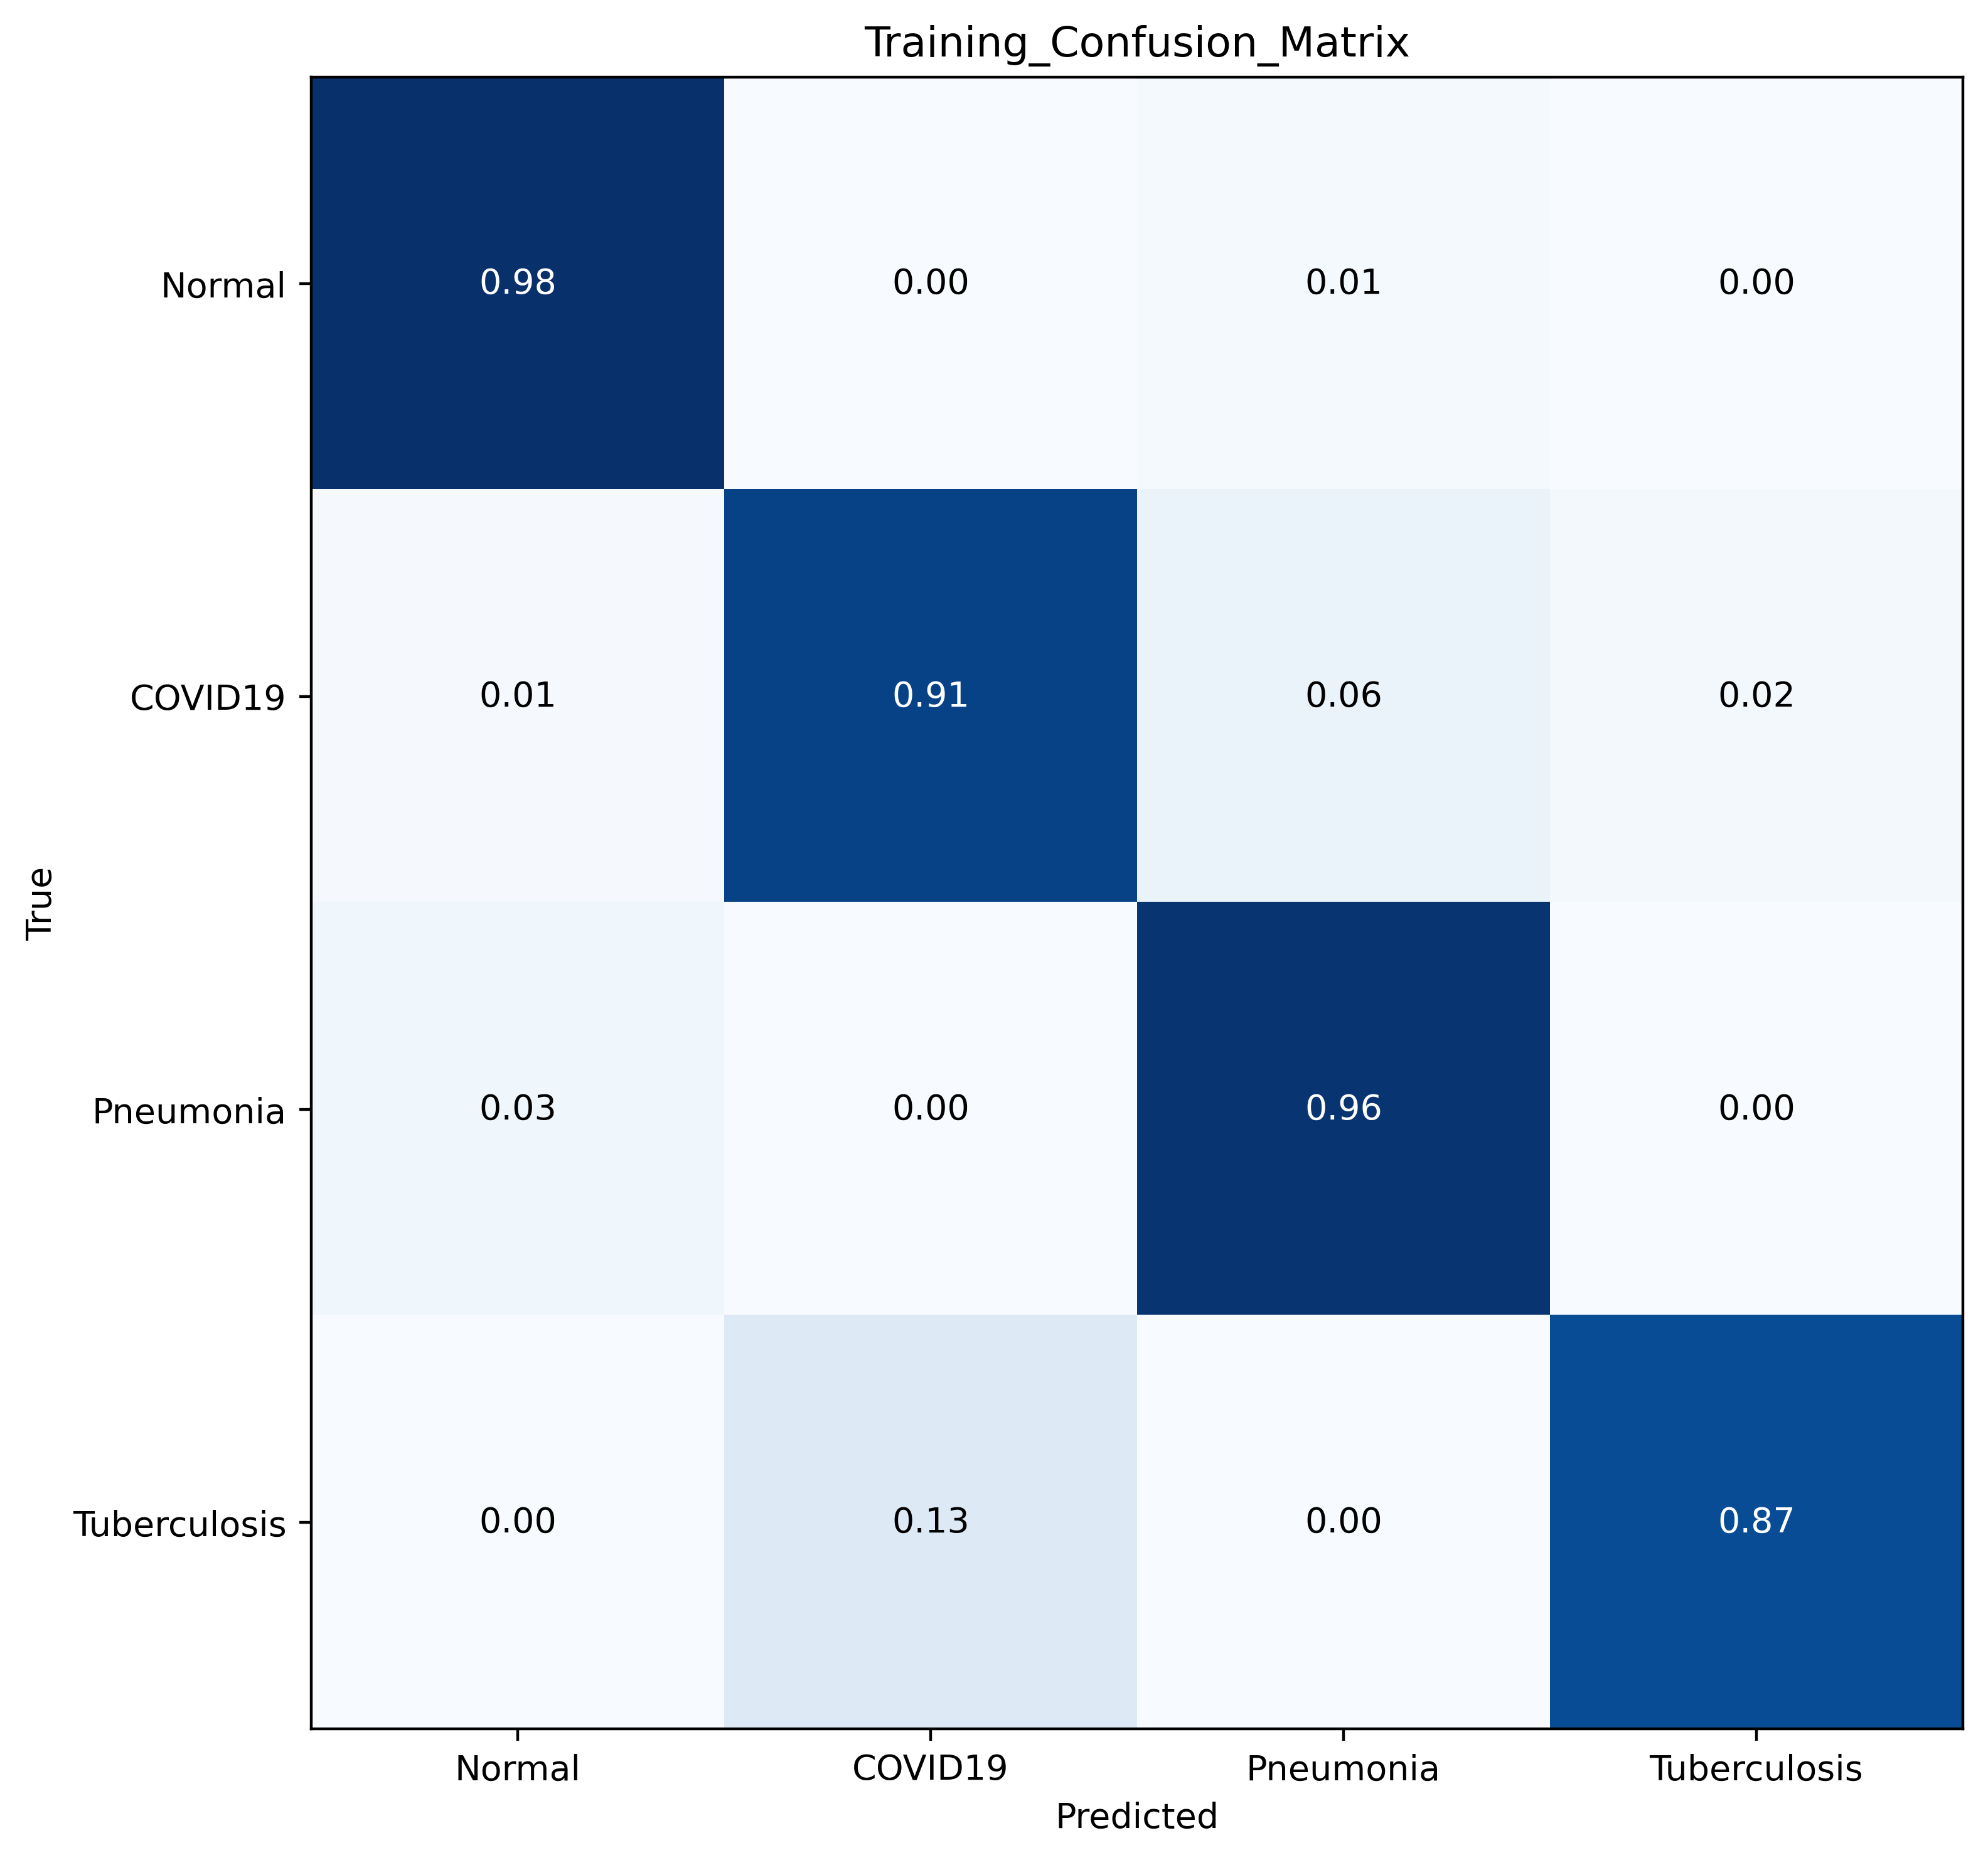

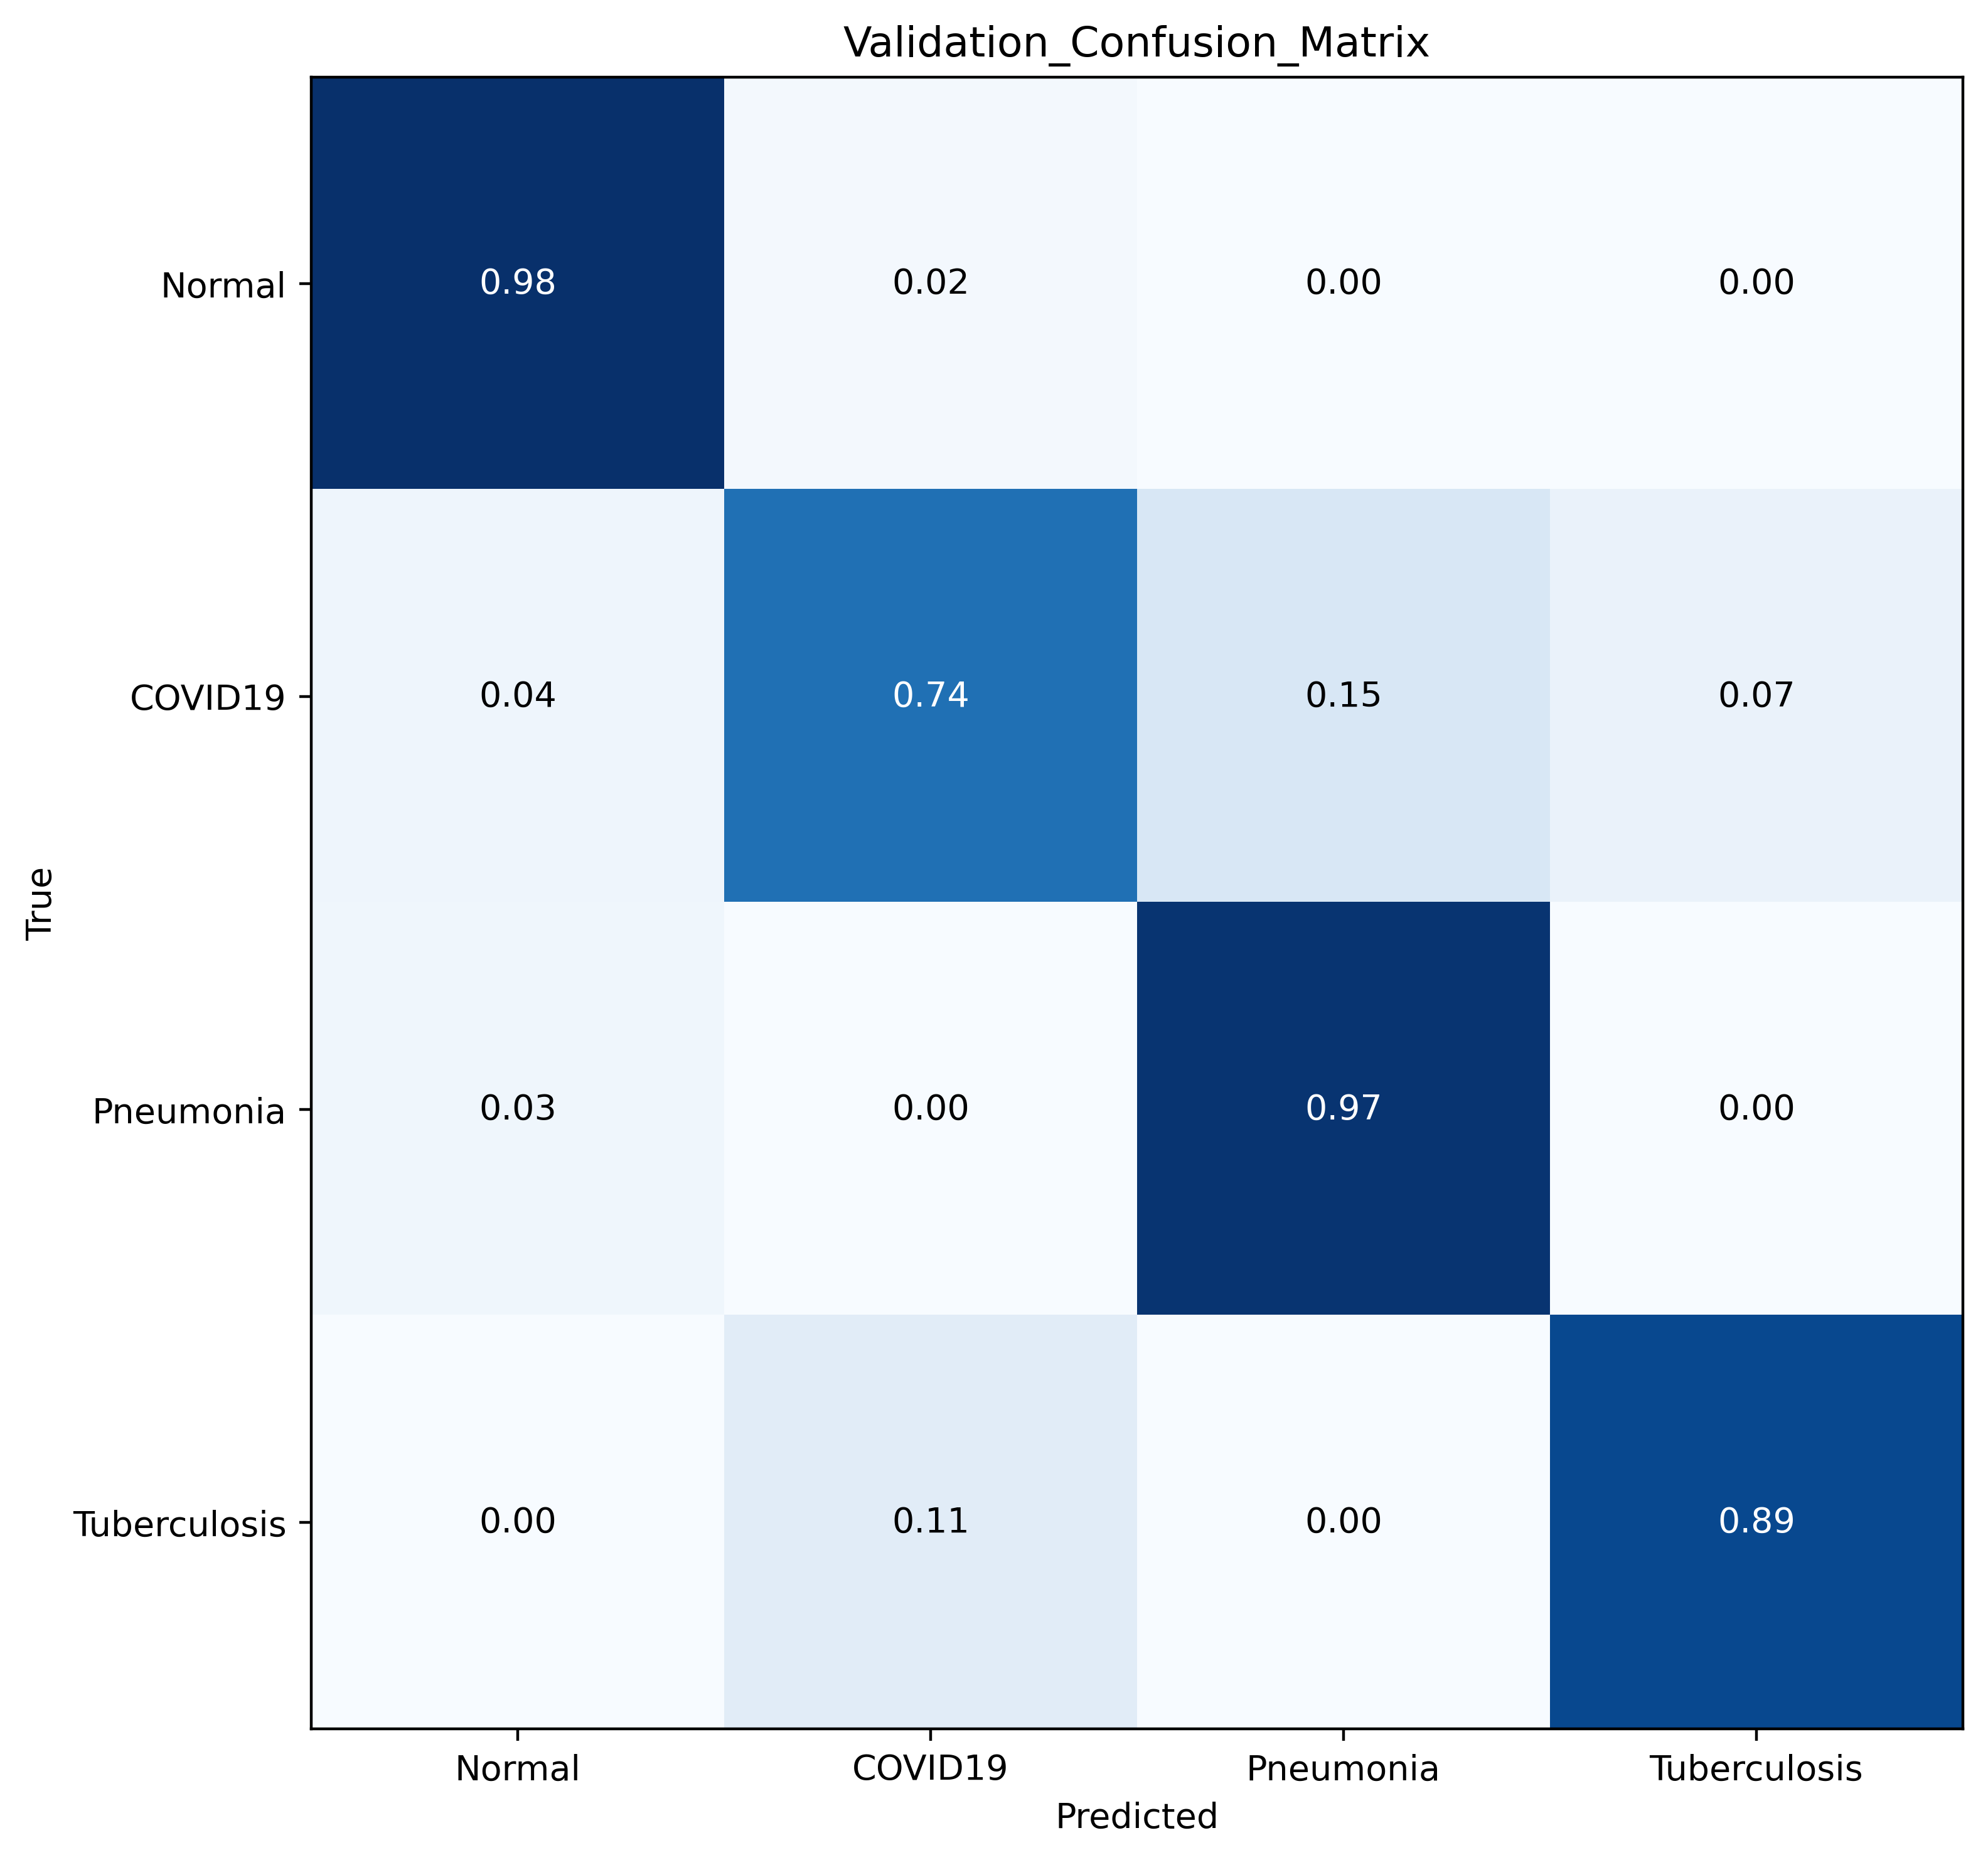

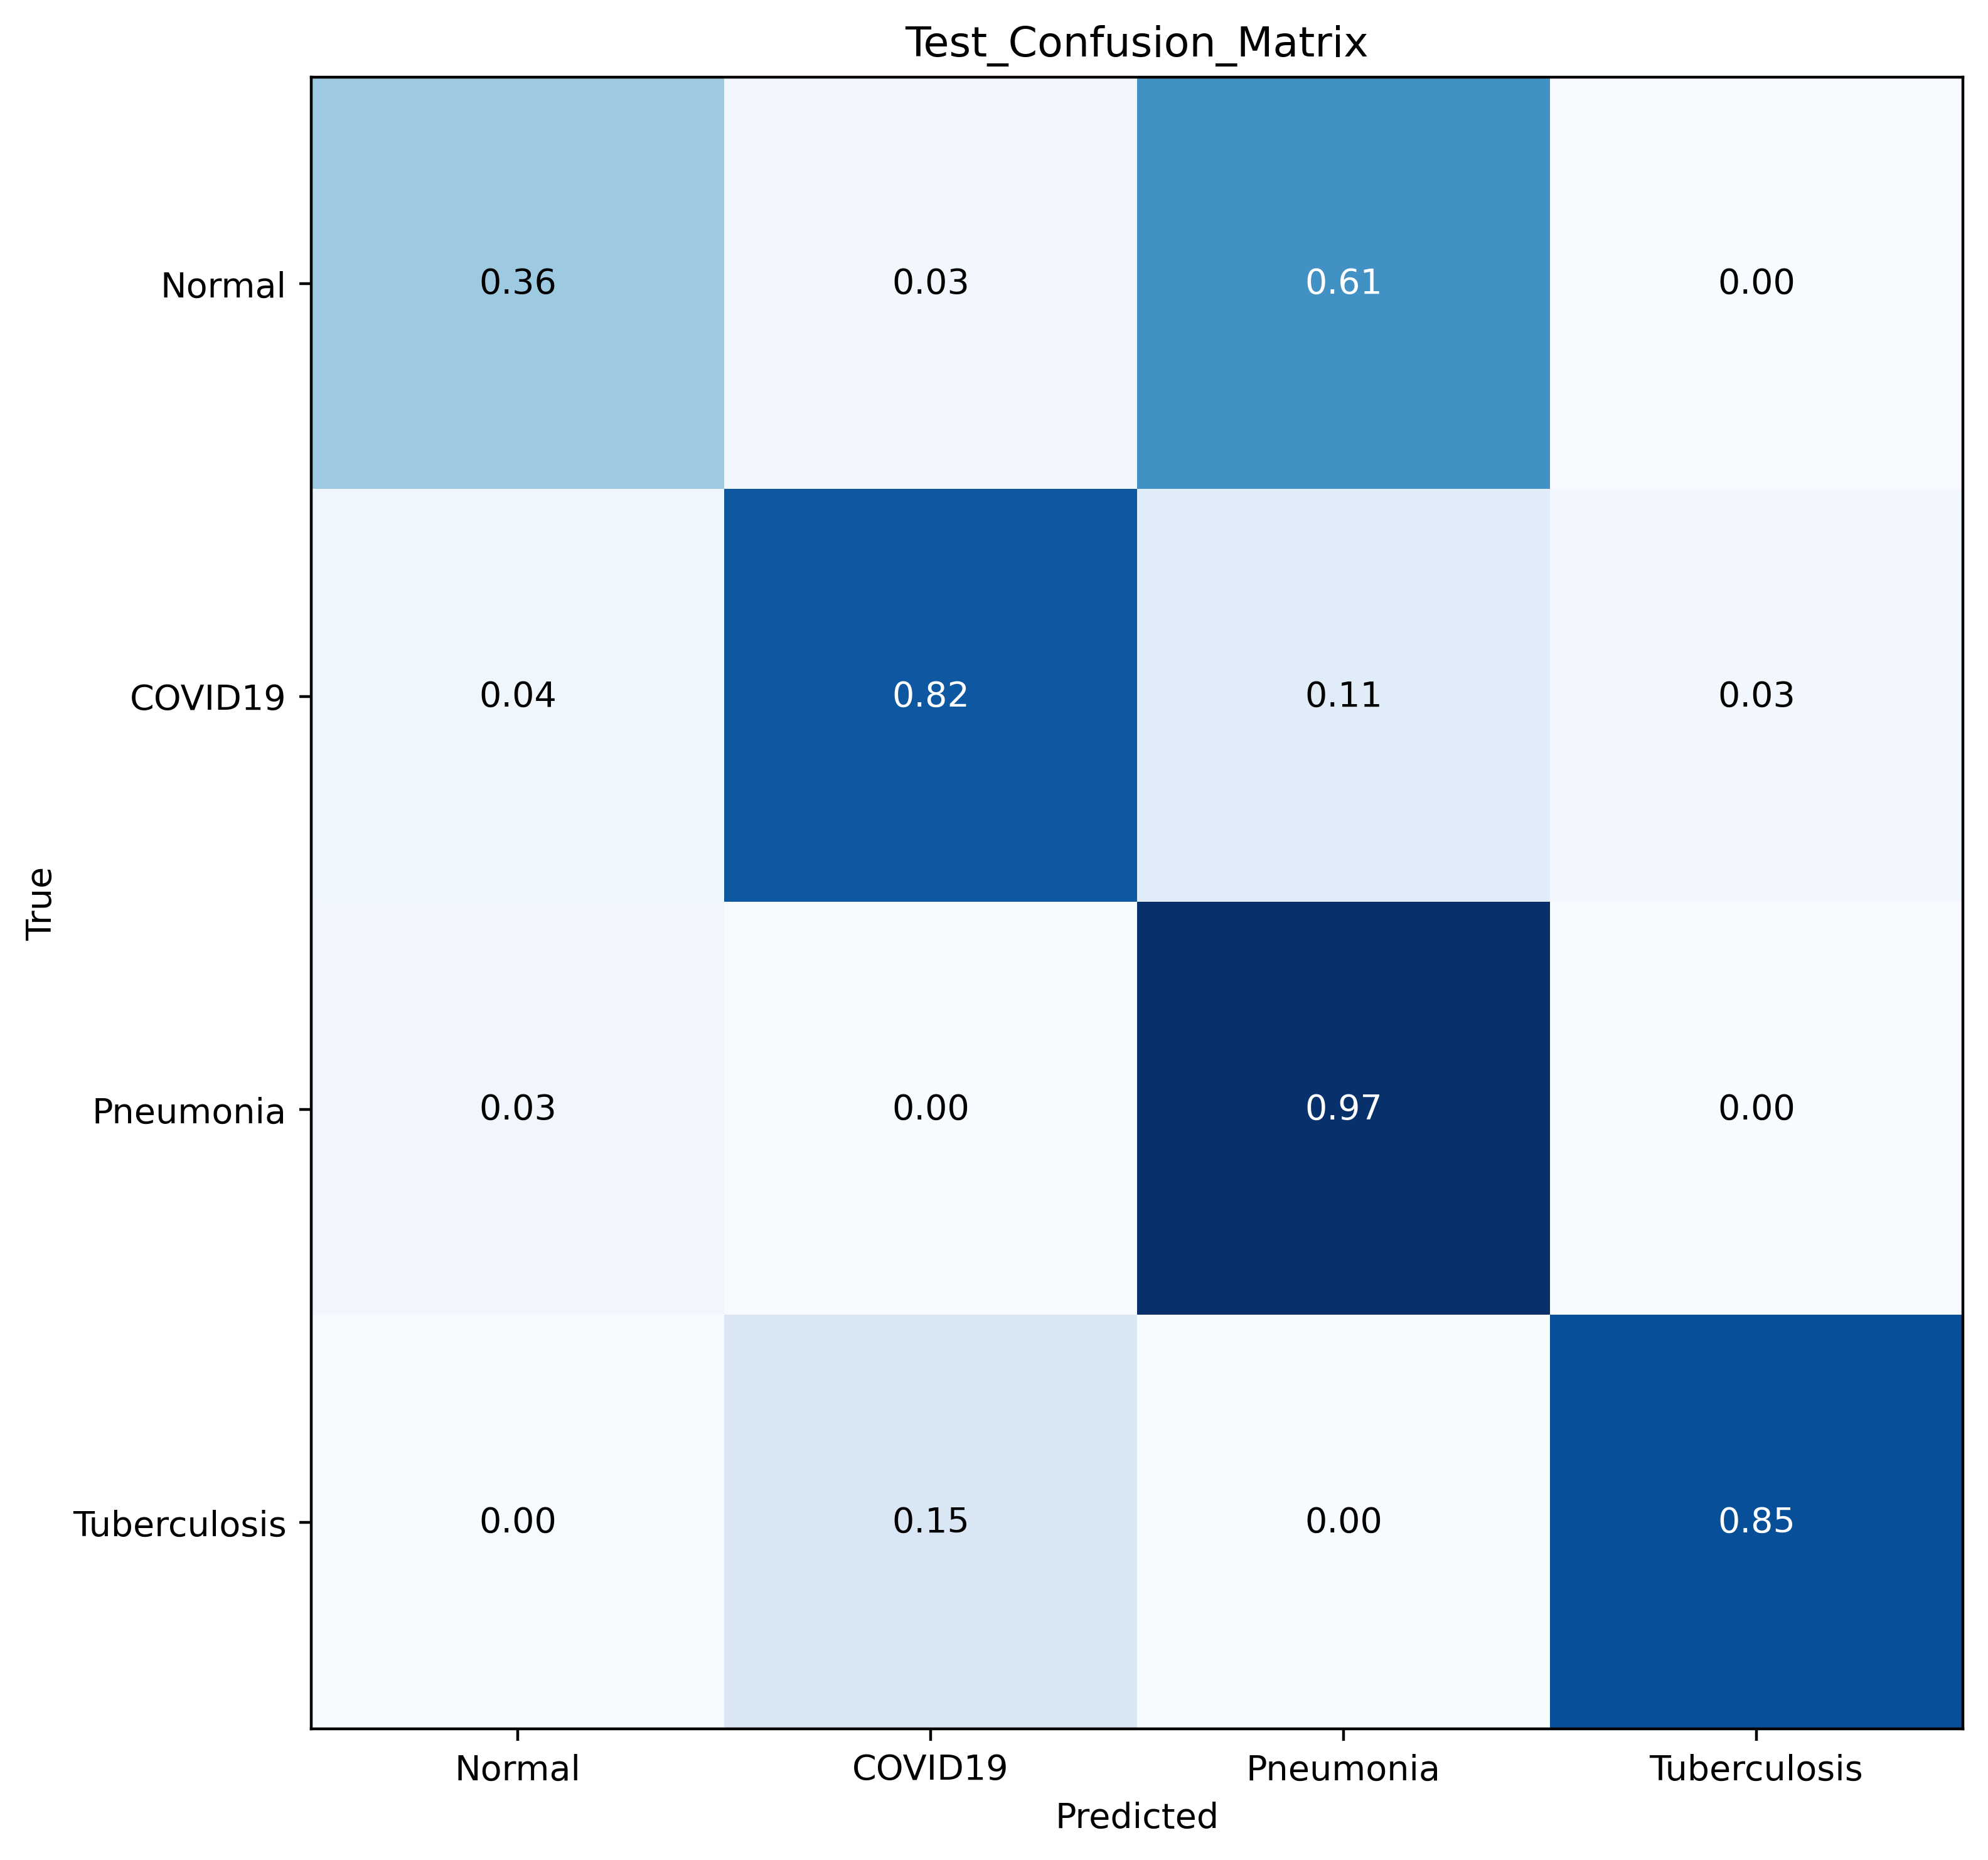

In [185]:
def plot_cm(cm, title):
    cm_sum = np.sum(cm, axis=1, keepdims=True) # cumulative sum
    cm_ratio = cm / cm_sum.astype(float) # so we display percetnages


    plt.figure(figsize=(8, 8), dpi=400)
    # plt.figure(figsize=(8, 8))
    plt.imshow(cm_ratio, cmap='Blues')
    plt.title(title)
    # plt.colorbar()

    classes = [0, 1, 2, 3]
    labels = ['Normal', 'COVID19', 'Pneumonia', 'Tuberculosis']
    class_labels = dict(zip(classes, labels))
    plt.xticks(ticks=classes, labels=class_labels.values())
    plt.yticks(ticks=classes, labels=class_labels.values())
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    
    # Loop through and add numbers to each box
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, f"{cm_ratio[i, j]:.2f}", 
                     ha="center", va="center", 
                     color="black" if cm_ratio[i, j] < 0.5 else "white")
            
    plt.tight_layout()
    plt.savefig(f"../assets/images/CNNRegularized/{title}_{data_type}.jpg", dpi=400)
    plt.show()

plot_cm(cm_train, 'Training_Confusion_Matrix')
plot_cm(cm_val, 'Validation_Confusion_Matrix')
plot_cm(cm_test, 'Test_Confusion_Matrix')

Summary stats

In [186]:
# using sklearn.metrics classification report function
print("Train Data Stats:")
print(classification_report(y_true_train, y_pred_train))

print("\nValidation Data Stats:")
print(classification_report(y_true_val, y_pred_val))

print("\nTest Data Stats:")
print(classification_report(y_true_test, y_pred_test))

Train Data Stats:
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1224
           1       0.82      0.91      0.86       424
           2       0.99      0.96      0.98      3482
           3       0.99      0.87      0.93       598

    accuracy                           0.95      5728
   macro avg       0.92      0.93      0.93      5728
weighted avg       0.96      0.95      0.95      5728


Validation Data Stats:
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       125
           1       0.79      0.74      0.76        46
           2       0.98      0.97      0.97       401
           3       0.95      0.89      0.92        64

    accuracy                           0.94       636
   macro avg       0.90      0.89      0.90       636
weighted avg       0.95      0.94      0.94       636


Test Data Stats:
              precision    recall  f1-score   support

           0   

## Model performances - Notes for previous models

### V2 Compressed

Train Data Stats:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1201
           1       1.00      1.00      1.00       417
           2       1.00      1.00      1.00      3491
           3       1.00      1.00      1.00       585

    accuracy                           1.00      5694
   macro avg       1.00      1.00      1.00      5694
weighted avg       1.00      1.00      1.00      5694


Validation Data Stats:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94       148
           1       0.84      0.87      0.85        53
           2       0.98      0.96      0.97       392
           3       0.91      0.95      0.93        77

    accuracy                           0.95       670
   macro avg       0.92      0.93      0.92       670
weighted avg       0.95      0.95      0.95       670


Test Data Stats:
              precision    recall  f1-score   support

           0       0.93      0.44      0.59       234
           1       0.87      0.89      0.88       106
           2       0.76      0.98      0.86       390
           3       0.85      0.95      0.90        41

    accuracy                           0.80       771
   macro avg       0.85      0.81      0.81       771
weighted avg       0.83      0.80      0.78       771


V2 Processed

Train Data Stats:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1194
           1       1.00      1.00      1.00       429
           2       1.00      1.00      1.00      3480
           3       1.00      1.00      1.00       591

    accuracy                           1.00      5694
   macro avg       1.00      1.00      1.00      5694
weighted avg       1.00      1.00      1.00      5694


Validation Data Stats:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       155
           1       0.84      1.00      0.91        41
           2       0.98      0.97      0.98       403
           3       1.00      0.96      0.98        71

    accuracy                           0.97       670
   macro avg       0.94      0.97      0.95       670
weighted avg       0.97      0.97      0.97       670


Test Data Stats:
              precision    recall  f1-score   support

           0       0.96      0.39      0.56       234
           1       0.88      0.93      0.91       106
           2       0.74      0.99      0.85       390
           3       0.98      0.98      0.98        41

    accuracy                           0.80       771
   macro avg       0.89      0.82      0.82       771
weighted avg       0.84      0.80      0.78       771
